In [15]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import classification_report

import seaborn as sns

In [16]:
def get_past_meta(
    df,
    row,
    n_past_meta,
    name_meta_col = "meta"
):
    idx = row.name
        
    list_past_meta = df.loc[idx-n_past_meta:idx - 1, name_meta_col].to_list()
    
    if len(list_past_meta) == 1:
        return str(list_past_meta[0])
        
    return tuple([str(i) for i in list_past_meta])


def predict(
    past_meta,
    df_probas
):
    
    # if this past_meta is not in df_proba
    if past_meta not in df_probas.columns:
        return float('nan')
    
    
    # create probability dict
    dict_probas = df_probas.loc[:,past_meta].to_dict()
    
    
    # get the meta with greater proba
    pred_meta = max(dict_probas, key=dict_probas.get)
    
    return pred_meta

def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report
    

In [17]:
# ### Definitions
path_data_dir = '../data/'

list_assets = ["PETR3.SA","PRIO3.SA", "VALE3.SA", "GGBR3.SA", "ABCB4.SA", "ITUB3.SA", "FLRY3.SA", "RADL3.SA"]

relevant_cols = ['Date', 'Close', 'Volume']




In [23]:
df_results = pd.DataFrame({})

for n_prev_meta in tqdm(range(1, 11)):

    for asset in list_assets:
        
        # get train contigency table 
        cont_tbl_train = pd.read_csv(path_data_dir + f"processed/train_contingency_table_price_history_{asset.replace('.', '_')}_meta_range({n_prev_meta})_dataset_ffill.csv", index_col=0, header=[i for i in range(n_prev_meta)])
        
        # create probability table
        df_probas = cont_tbl_train.apply(lambda x: [col/sum(x) for col in x])    
        
        # get test dataset
        test_dataset = pd.read_csv(path_data_dir + f"processed/test_price_history_{asset.replace('.', '_')}_meta_dataset_ffill.csv", index_col= 0)
        
        # get the past meta for all days    
        test_dataset["past_meta"] = test_dataset.apply(lambda x: get_past_meta(test_dataset,x,n_prev_meta,name_meta_col = "meta"), axis=1)

        # remove the first rows
        test_dataset = test_dataset.iloc[n_prev_meta:]
        
        # get y_test
        y_test = test_dataset.meta
        
        # predict based on probability table
        y_pred = test_dataset.past_meta.apply(lambda x: predict(x, df_probas))
        
        # when the value is nan, repeat the last predict
        y_pred.ffill(inplace=True)
        y_pred.fillna(0, inplace = True)
        
        # create df with results
        df_results_p = get_classification_report(y_test, y_pred)
        df_results_p['asset'] = asset
        df_results_p['n_prev_meta'] = n_prev_meta
        
        df_results = pd.concat([df_results, df_results_p])
        
        
        if n_prev_meta == 1:
            
            # predict based on probability table
            y_pred = test_dataset.past_meta.astype('int')
            
            # when the value is nan, repeat the last predict
            y_pred.ffill(inplace=True)
            y_pred.fillna(0, inplace = True)
            
            # create df with results
            df_results_p = get_classification_report(y_test, y_pred)
            df_results_p['asset'] = asset
            df_results_p['n_prev_meta'] = 'DUMMY'
            
            df_results = pd.concat([df_results, df_results_p])

  0%|          | 0/10 [00:00<?, ?it/s]/home/semcovici/anaconda3/envs/env-tcc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/env-tcc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/env-tcc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [24]:
df_results= df_results.reset_index().rename({'index': 'class'}, axis = 1)
df_results

,class,precision,recall,f1-score,support,asset,n_prev_meta
0,0,0.846983,0.846983,0.846983,464.000000,PETR3.SA,1
1,accuracy,0.787321,0.787321,0.787321,0.787321,PETR3.SA,1
2,weighted avg,0.783856,0.787321,0.785531,978.000000,PETR3.SA,1
3,-1,0.771429,0.771429,0.771429,175.000000,PETR3.SA,1
4,1,0.769874,0.769874,0.769874,239.000000,PETR3.SA,1
...,...,...,...,...,...,...,...
827,macro avg,0.139798,0.144927,0.142290,969.000000,RADL3.SA,10
828,-3.0,0.000000,0.000000,0.000000,0.000000,RADL3.SA,10
829,-2.0,0.000000,0.000000,0.000000,50.000000,RADL3.SA,10
830,2.0,0.000000,0.000000,0.000000,30.000000,RADL3.SA,10


In [29]:
df_f1_macro = df_results[
    (df_results['class'] == 'macro avg') &
    (df_results['n_prev_meta'] != 'DUMMY')
    ][['f1-score', 'asset' ,'n_prev_meta']]
df_f1_macro

,f1-score,asset,n_prev_meta
7,0.507931,PETR3.SA,1
24,0.740448,PRIO3.SA,1
43,0.621226,VALE3.SA,1
63,0.557122,GGBR3.SA,1
83,0.571628,ABCB4.SA,1
...,...,...,...
789,0.176620,GGBR3.SA,10
799,0.161087,ABCB4.SA,10
808,0.178747,ITUB3.SA,10
818,0.223818,FLRY3.SA,10


<Axes: xlabel='n_prev_meta', ylabel='f1-score'>

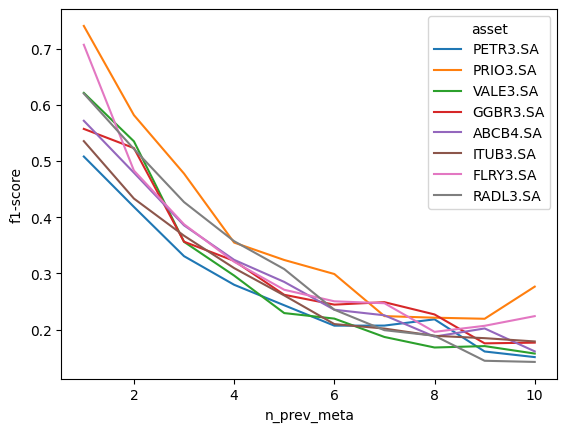

In [30]:
sns.lineplot(data=df_f1_macro, x="n_prev_meta", y="f1-score", hue="asset")

In [33]:
df_results[
    (df_results['class'] == 'macro avg') &
    (df_results['n_prev_meta'] == 'DUMMY')
    ][['f1-score', 'asset' ,'n_prev_meta']].sort_values('asset')

,f1-score,asset,n_prev_meta
92,0.569987,ABCB4.SA,DUMMY
128,0.706896,FLRY3.SA,DUMMY
73,0.652389,GGBR3.SA,DUMMY
111,0.533842,ITUB3.SA,DUMMY
15,0.697414,PETR3.SA,DUMMY
32,0.740448,PRIO3.SA,DUMMY
147,0.612325,RADL3.SA,DUMMY
53,0.690939,VALE3.SA,DUMMY


In [35]:
df_results[
    (df_results['class'] == 'macro avg') &
    (df_results['n_prev_meta'] == 1)
    ][['f1-score', 'asset' ,'n_prev_meta']].sort_values('asset')

,f1-score,asset,n_prev_meta
83,0.571628,ABCB4.SA,1
119,0.706896,FLRY3.SA,1
63,0.557122,GGBR3.SA,1
101,0.535368,ITUB3.SA,1
7,0.507931,PETR3.SA,1
24,0.740448,PRIO3.SA,1
138,0.620031,RADL3.SA,1
43,0.621226,VALE3.SA,1
